# DefCoordML

This project simulates the role of an **AI-powered NFL Defensive Coordinator**, designed to anticipate whether the offense will **pass** or **rush** before the snap. By analyzing historical NFL play-by-play data, the model learns situational tendencies and informs smarter, faster defensive play calls.

Objectives:
- Load and clean historical NFL play-by-play data
- Engineer relevant pre-snap features (e.g., down, distance, score differential, formation)
- Visualize trends in passing vs rushing behavior
- Train and compare three different classification algorithms, testing three hyperparameter sets for each
- Evaluate model performance and interpret key features

Target:
- **`play_type`**: Binary classification target  
  - `pass` (1)
  - `rush` (0)

Dataset:
- NFL Seasons: 2014–2023
- Source: `nfl_data_py.load_pbp_data()`

Shaan Patel, Aug. 2025

## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nfl_data_py import import_pbp_data
import missingno as msno
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import time
import logging
import math

## Load Data

In [2]:
# Load data
df = import_pbp_data(list(range(2014,2024)))

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


Checking all columns for useful features

In [3]:
# General data information
df.info()
df.describe(include='all')

# Look at all columns
def show_columns(df, n_cols):
    cols = df.columns.tolist()
    rows = (len(cols) + n_cols - 1) // n_cols  # ceiling division
    columns = [cols[i*rows:(i+1)*rows] for i in range(n_cols)]

    df_cols = pd.DataFrame(columns).fillna('')
    display(df_cols)

show_columns(df, n_cols=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481742 entries, 0 to 481741
Columns: 398 entries, play_id to defense_numbers
dtypes: float32(205), int32(7), int64(1), object(185)
memory usage: 1.0+ GB


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch
1,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,...,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa
2,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,...,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked
3,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,...,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt
4,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,...,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id
5,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,...,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackle_4_team,tackle_with_assist
6,tackle_with_assist_1_player_id,tackle_with_assist_1_player_name,tackle_with_assist_1_team,tackle_with_assist_2_player_id,tackle_with_assist_2_player_name,tackle_with_assist_2_team,pass_defense_1_player_id,pass_defense_1_player_name,pass_defense_2_player_id,pass_defense_2_player_name,...,return_team,return_yards,penalty_team,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt
7,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,safety_player_name,safety_player_id,season,cp,cpoe,series,series_success,...,drive_inside20,drive_ended_with_score,drive_quarter_start,drive_quarter_end,drive_yards_penalized,drive_start_transition,drive_end_transition,drive_game_clock_start,drive_game_clock_end,drive_start_yard_line
8,drive_end_yard_line,drive_play_id_started,drive_play_id_ended,away_score,home_score,location,result,total,spread_line,total_line,...,special,play,passer_id,rusher_id,receiver_id,name,jersey_number,id,fantasy_player_name,fantasy_player_id
9,fantasy,fantasy_id,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,...,defense_man_zone_type,defense_coverage_type,offense_names,defense_names,offense_positions,defense_positions,offense_numbers,defense_numbers,,


## Extract Features

The features chosen focus on capturing key aspects of the offensive play and game context to influence whether the upcoming play is a pass or a rush. These include:

- **Offensive formation and personnel:** Reflect the offensive setup and player roles on the field.
- **Game context:** Includes down, yards needed for a first down, remaining time in the quarter and game, and the current score margin to gauge the situation (how urgent the offense needs to be).
- **Play characteristics:** Details such as pass length, air yards, run direction, and gap to describe the play design.
- **Drive and team factors:** Information like the number of plays in the drive, whether the team is home or away, and coaching staff, which can impact playcalling patterns.

In [4]:
# Get new DataFrame with relevant information, sorted by Game/Drive
featuredf = (
    df[
        ((df["pass"].notna()) | (df["rush"].notna()))         # pass OR rush not null
        & (df["offense_formation"].notna())                   # offense_formation not null
        & (df["offense_personnel"].notna())                   # offense_personnel not null
    ]
    .sort_values(by=["game_id", "drive", "game_seconds_remaining"], ascending=[True, True, False])
    [[
        "game_id", 'offense_formation', 'offense_personnel', "drive", "game_seconds_remaining", 
        "quarter_seconds_remaining", "goal_to_go", "yrdln", "pass_length", "posteam", "air_yards", 
        "run_location", "run_gap", "down", "ydstogo", "ydsnet", "yards_gained", "posteam_type", 
        "home_coach", "away_coach", "play_type", "drive_play_count", "score_differential", "pass", 
        "rush", "play"
    ]]
)

featuredf.head(10)

,game_id,offense_formation,offense_personnel,drive,game_seconds_remaining,quarter_seconds_remaining,goal_to_go,yrdln,pass_length,posteam,...,yards_gained,posteam_type,home_coach,away_coach,play_type,drive_play_count,score_differential,pass,rush,play
95753,2016_01_BUF_BAL,I_FORM,"2 RB, 1 TE, 2 WR",1.0,3597.0,897.0,0,BAL 14,None,BAL,...,6.0,home,John Harbaugh,Rex Ryan,run,5.0,0.0,0.0,1.0,1.0
95754,2016_01_BUF_BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",1.0,3572.0,872.0,0,BAL 20,short,BAL,...,5.0,home,John Harbaugh,Rex Ryan,pass,5.0,0.0,1.0,0.0,1.0
95755,2016_01_BUF_BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",1.0,3541.0,841.0,0,BAL 25,None,BAL,...,0.0,home,John Harbaugh,Rex Ryan,run,5.0,0.0,0.0,1.0,1.0
95756,2016_01_BUF_BAL,I_FORM,"2 RB, 1 TE, 2 WR",1.0,3515.0,815.0,0,BAL 25,short,BAL,...,9.0,home,John Harbaugh,Rex Ryan,pass,5.0,0.0,1.0,0.0,1.0
95757,2016_01_BUF_BAL,I_FORM,"1 RB, 2 TE, 2 WR",1.0,3474.0,774.0,0,BAL 34,None,BAL,...,0.0,home,John Harbaugh,Rex Ryan,run,5.0,0.0,0.0,1.0,1.0
95760,2016_01_BUF_BAL,SHOTGUN,"1 RB, 2 TE, 2 WR",2.0,3404.0,704.0,0,BUF 32,short,BUF,...,2.0,away,John Harbaugh,Rex Ryan,pass,3.0,0.0,1.0,0.0,1.0
95761,2016_01_BUF_BAL,SHOTGUN,"6 OL, 1 RB, 2 TE, 1 WR",2.0,3362.0,662.0,0,BUF 34,None,BUF,...,-6.0,away,John Harbaugh,Rex Ryan,run,3.0,0.0,0.0,1.0,1.0
95762,2016_01_BUF_BAL,SHOTGUN,"1 RB, 1 TE, 3 WR",2.0,3315.0,615.0,0,BUF 28,short,BUF,...,-4.0,away,John Harbaugh,Rex Ryan,pass,3.0,0.0,1.0,0.0,1.0
95764,2016_01_BUF_BAL,SHOTGUN,"1 RB, 2 TE, 2 WR",3.0,3273.0,573.0,0,BAL 34,short,BAL,...,3.0,home,John Harbaugh,Rex Ryan,pass,5.0,0.0,1.0,0.0,1.0
95765,2016_01_BUF_BAL,SHOTGUN,"1 RB, 2 TE, 2 WR",3.0,3245.0,545.0,0,BAL 37,short,BAL,...,6.0,home,John Harbaugh,Rex Ryan,pass,5.0,0.0,1.0,0.0,1.0


## EDA

### Check Values
Checking for missing values 

run_gap             204330
run_location        173935
pass_length         135200
air_yards           135096
down                  1062
yards_gained           204
drive                   45
ydsnet                  45
drive_play_count        45
dtype: int64


<Axes: >

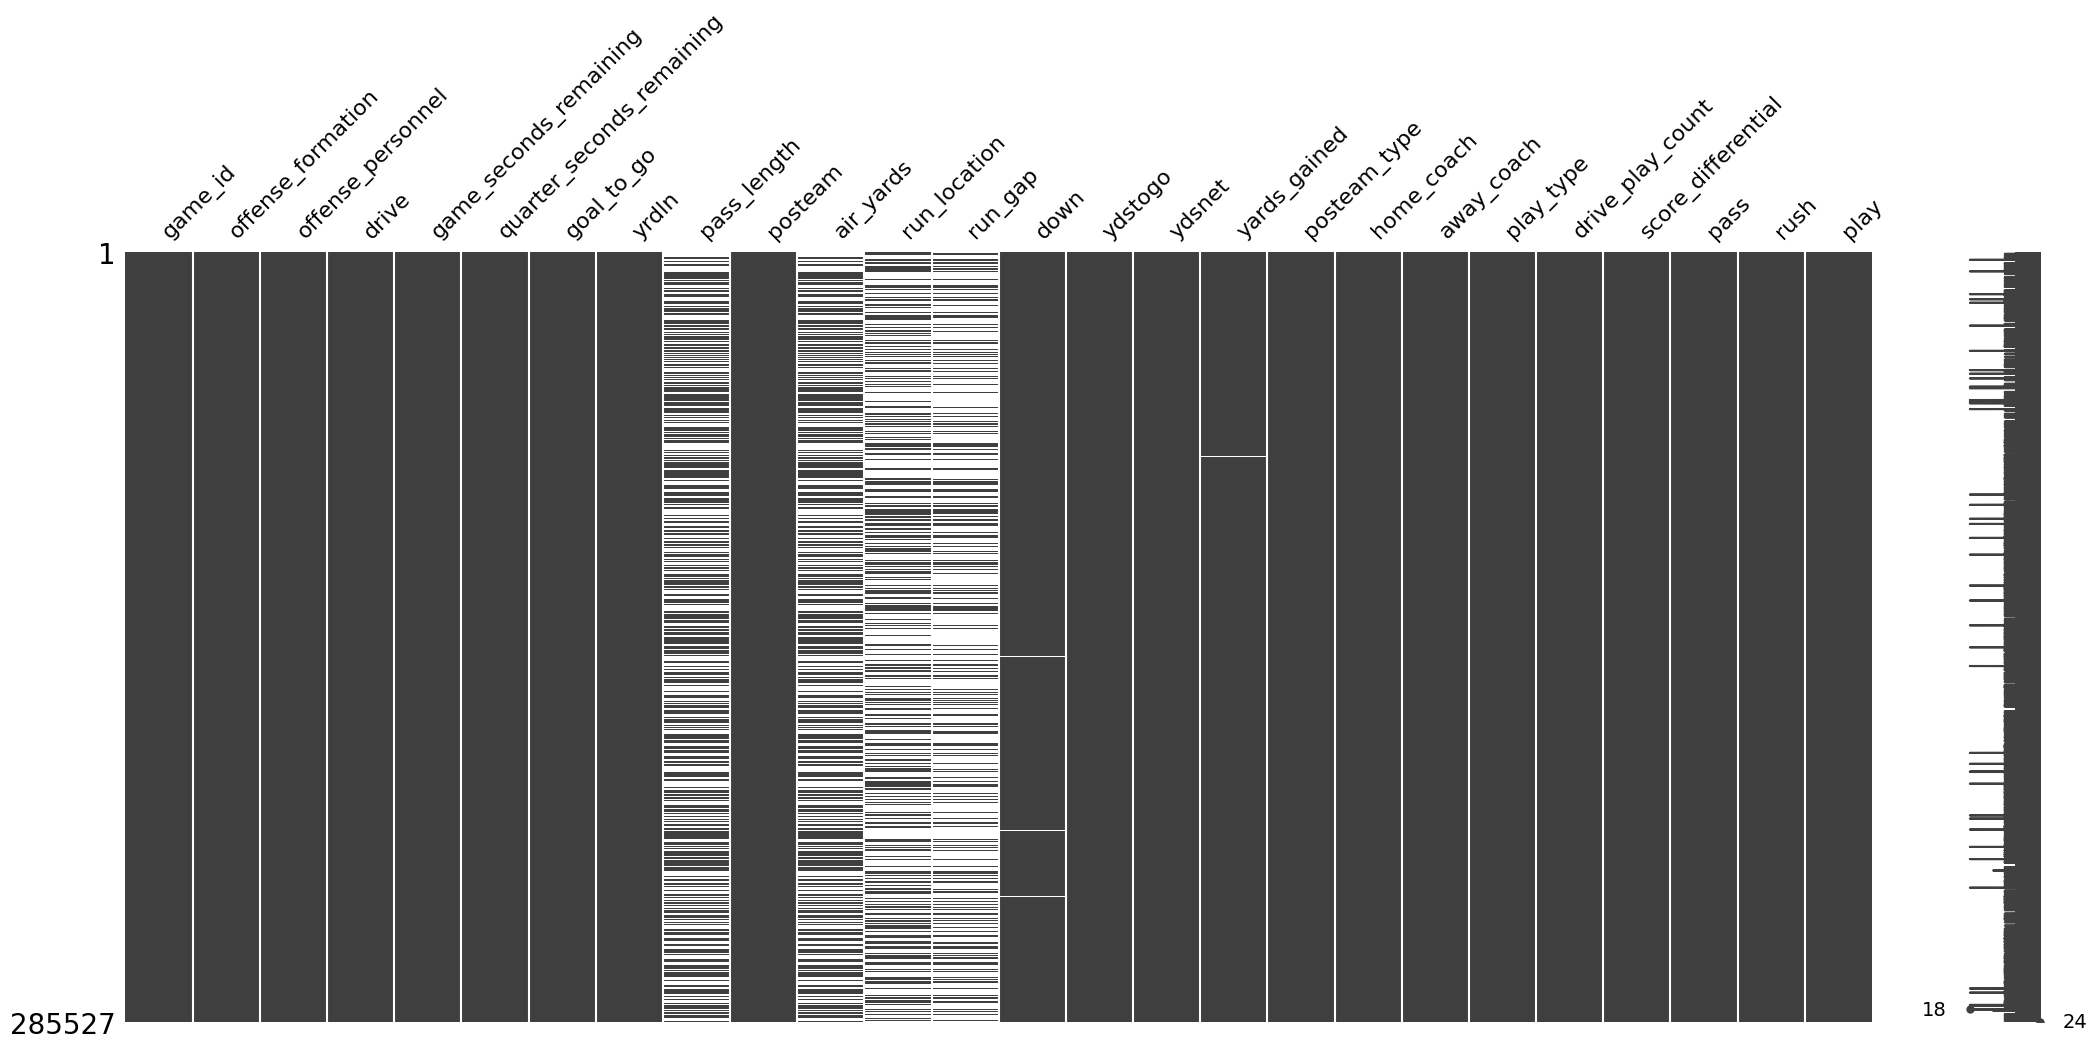

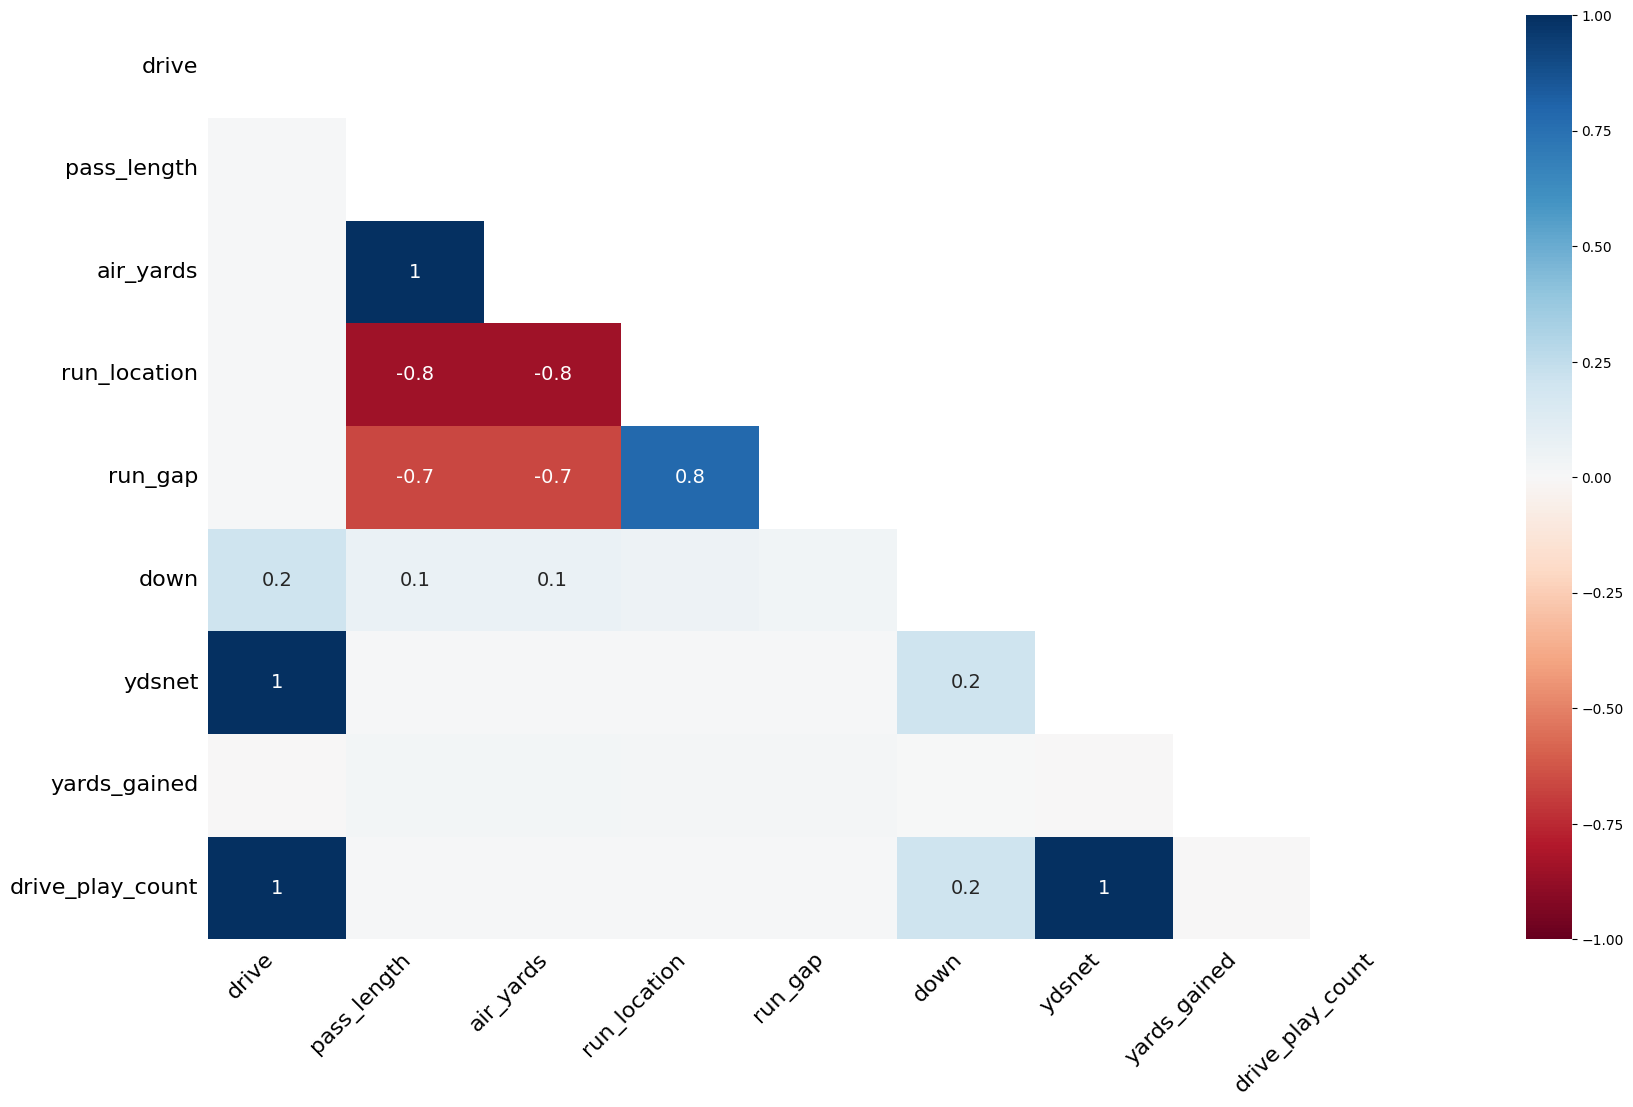

In [5]:
missing = featuredf.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

msno.matrix(featuredf)

msno.heatmap(featuredf)

### Check Distribution
Checking target distribution for skewed data

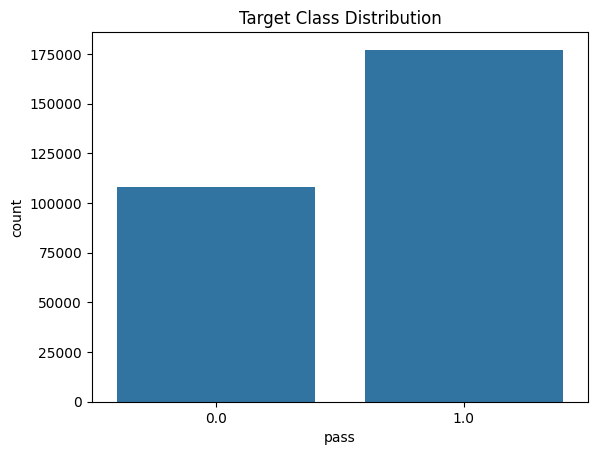

Class distribution:
1.0    0.620589
0.0    0.379411
Name: pass, dtype: float64


In [6]:
target = 'pass'

# Check class distribution
sns.countplot(x=target, data=featuredf)
plt.title("Target Class Distribution")
plt.show()

print("Class distribution:")
print(featuredf[target].value_counts(normalize=True))

### Num/Cat Analysis
Visualizes distribution of numerical features and top 10 categories of categorical features

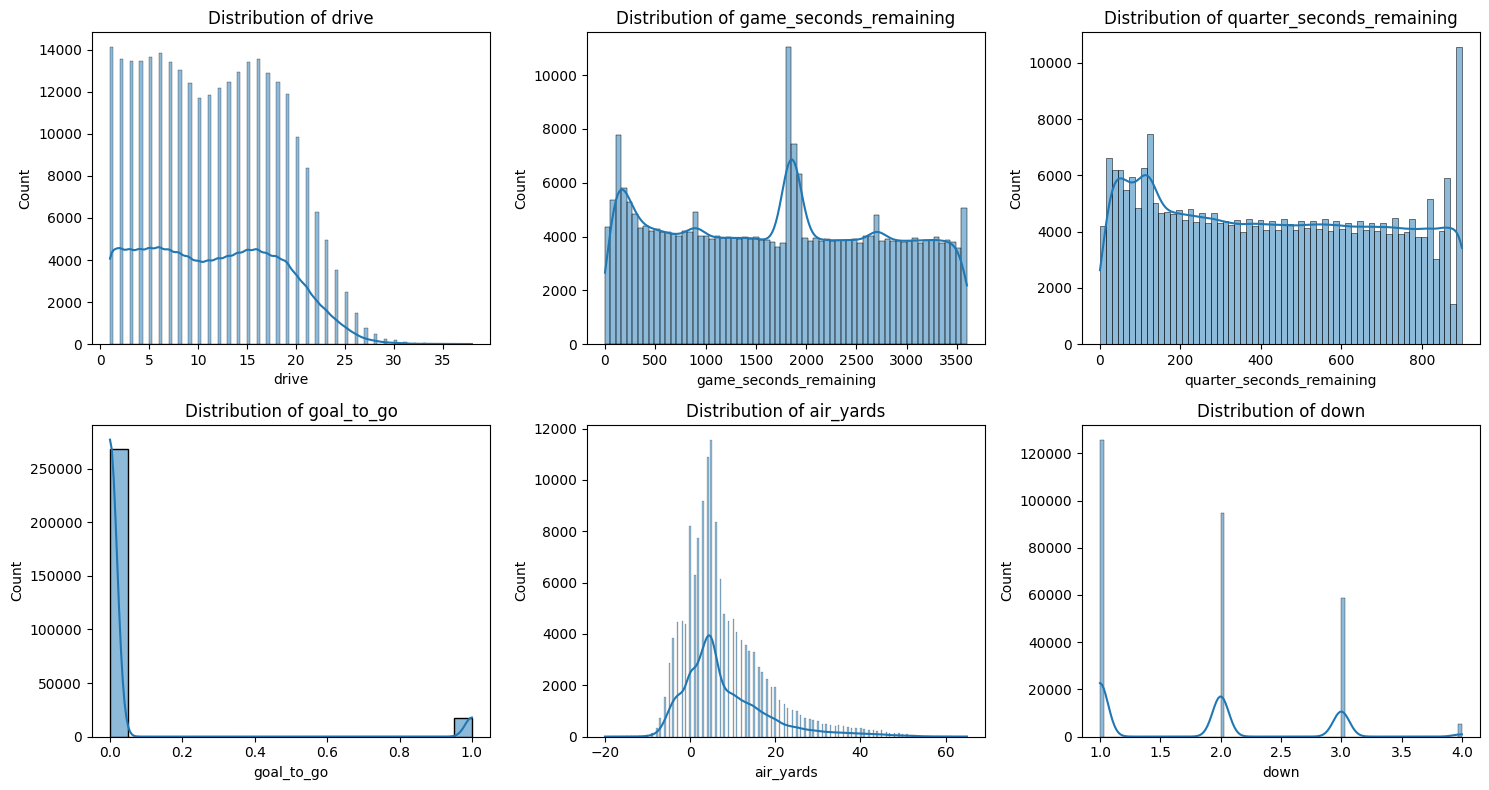

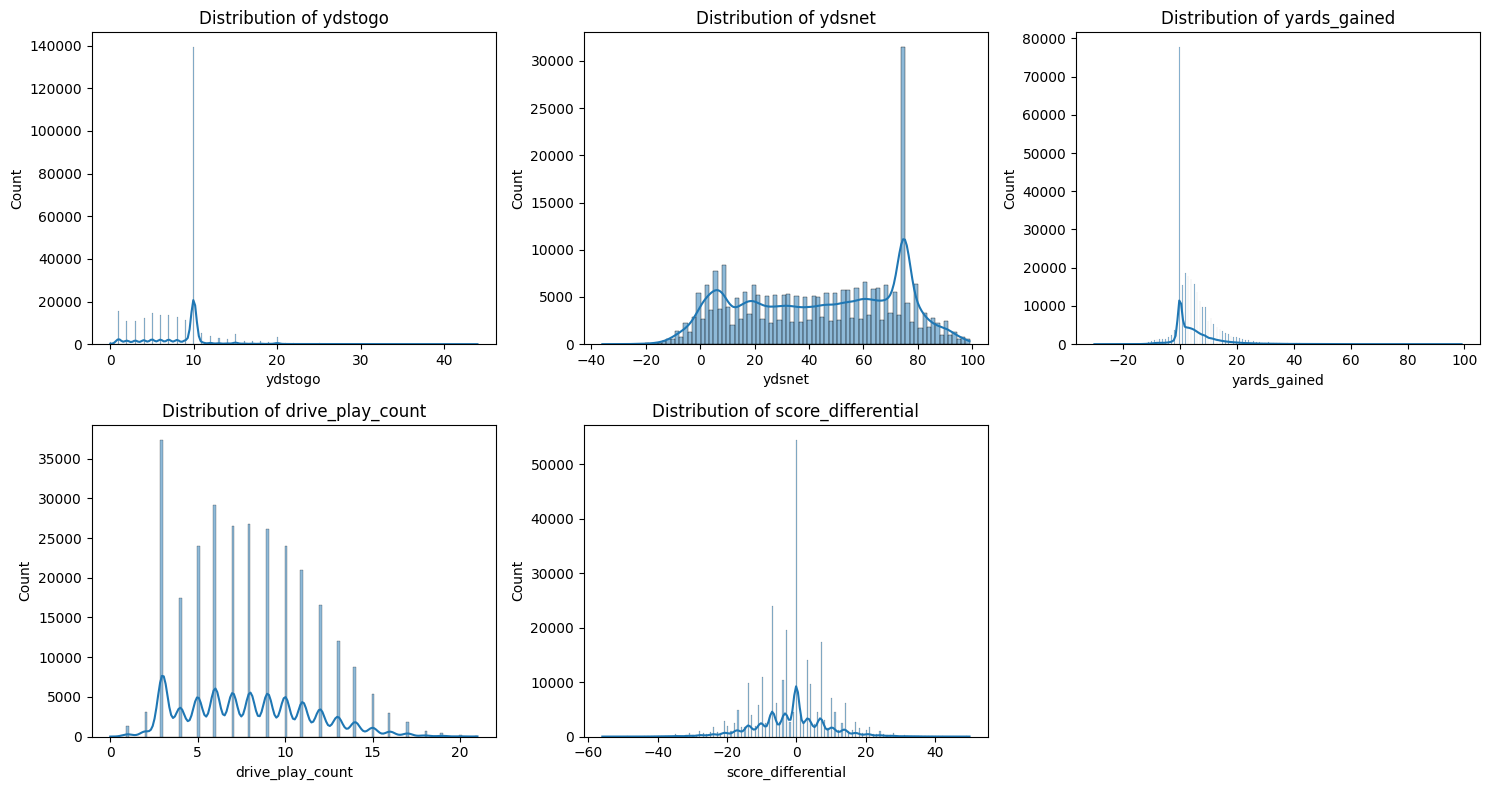

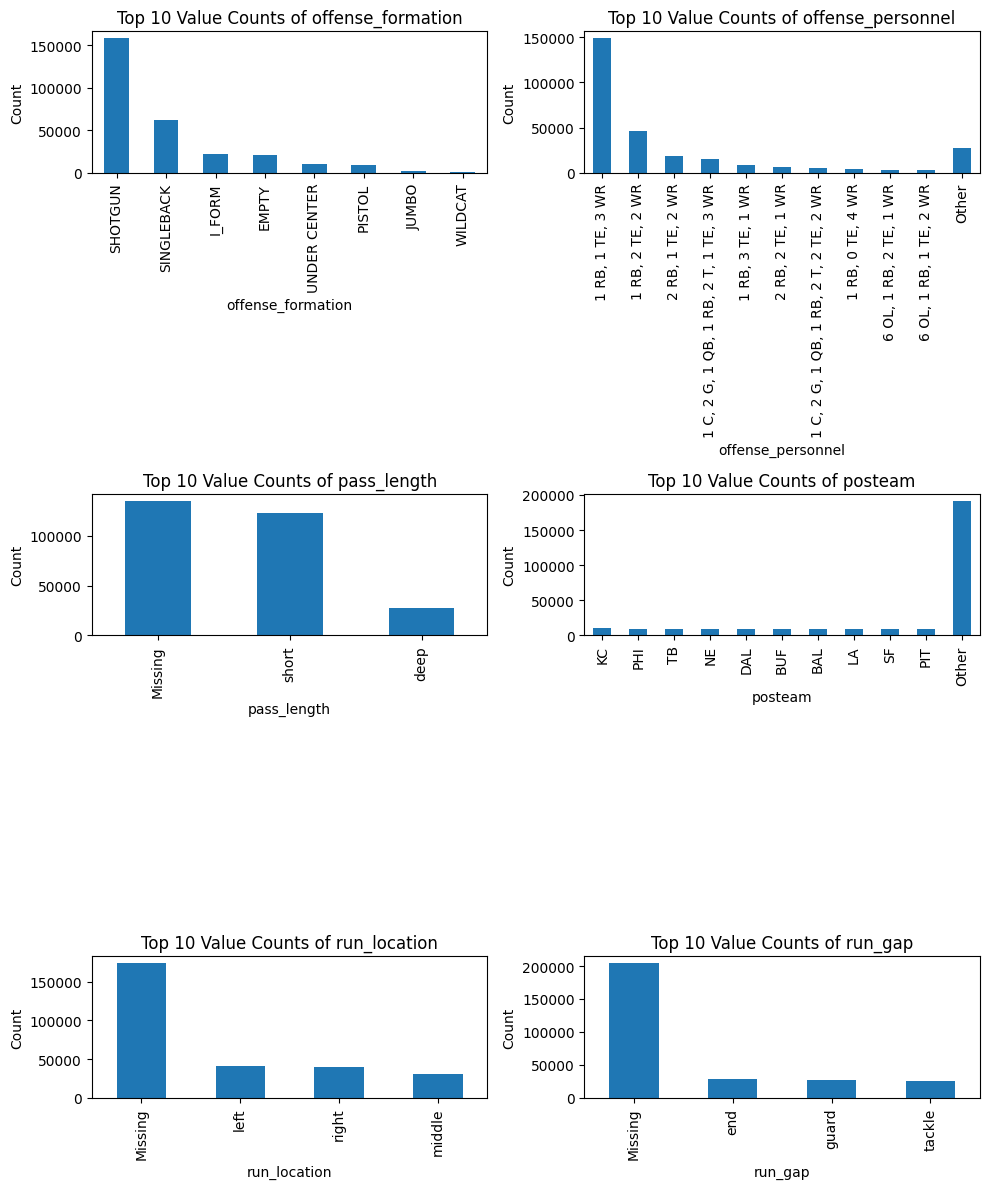

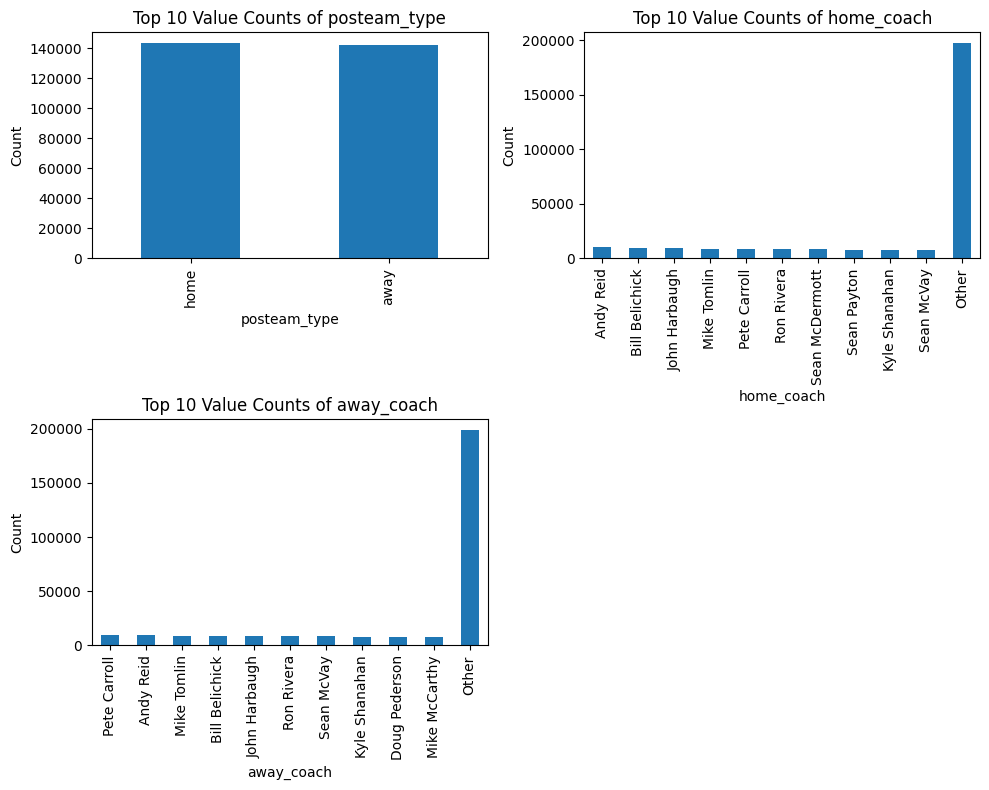

In [7]:
logging.getLogger('matplotlib.category').setLevel(logging.WARNING)

def plot_numerical_distributions(df, num_cols, plots_per_batch=6, plots_per_row=3):
    batches = math.ceil(len(num_cols) / plots_per_batch)

    for b in range(batches):
        batch_cols = num_cols[b * plots_per_batch : (b + 1) * plots_per_batch]
        num_plots = len(batch_cols)
        num_rows = math.ceil(num_plots / plots_per_row)

        fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 5, num_rows * 4))
        axes = axes.flatten() if num_plots > 1 else [axes]

        for i, col in enumerate(batch_cols):
            sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()


def plot_categorical_distributions(df, cat_cols, plots_per_batch=6, plots_per_row=2):
    batches = math.ceil(len(cat_cols) / plots_per_batch)

    for b in range(batches):
        batch_cols = cat_cols[b * plots_per_batch : (b + 1) * plots_per_batch]
        num_plots = len(batch_cols)
        num_rows = math.ceil(num_plots / plots_per_row)

        fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 5, num_rows * 4))
        axes = axes.flatten() if num_plots > 1 else [axes]

        for i, col in enumerate(batch_cols):
            vc = df[col].fillna('Missing').value_counts()
            top = vc.head(10)
            rest = vc.iloc[10:].sum()
            if rest > 0:
                top['Other'] = rest
            top.plot(kind='bar', ax=axes[i])
            axes[i].set_title(f"Top 10 Value Counts of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Count")

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()

# Exclude certain columns
exclude_cols = ['rush', 'pass', 'play', 'game_id', 'yrdln', 'play_type']

# Select num vs. cat columns
num_cols = featuredf.select_dtypes(include=['number']).drop(columns=exclude_cols, errors='ignore').columns
cat_cols = featuredf.select_dtypes(include=['object', 'category']).drop(columns=exclude_cols, errors='ignore').columns

# Plot
plot_numerical_distributions(featuredf, num_cols)
plot_categorical_distributions(featuredf, cat_cols)

### Feature-Target Relationship
Explores the relationship between features and the target variable ('pass')

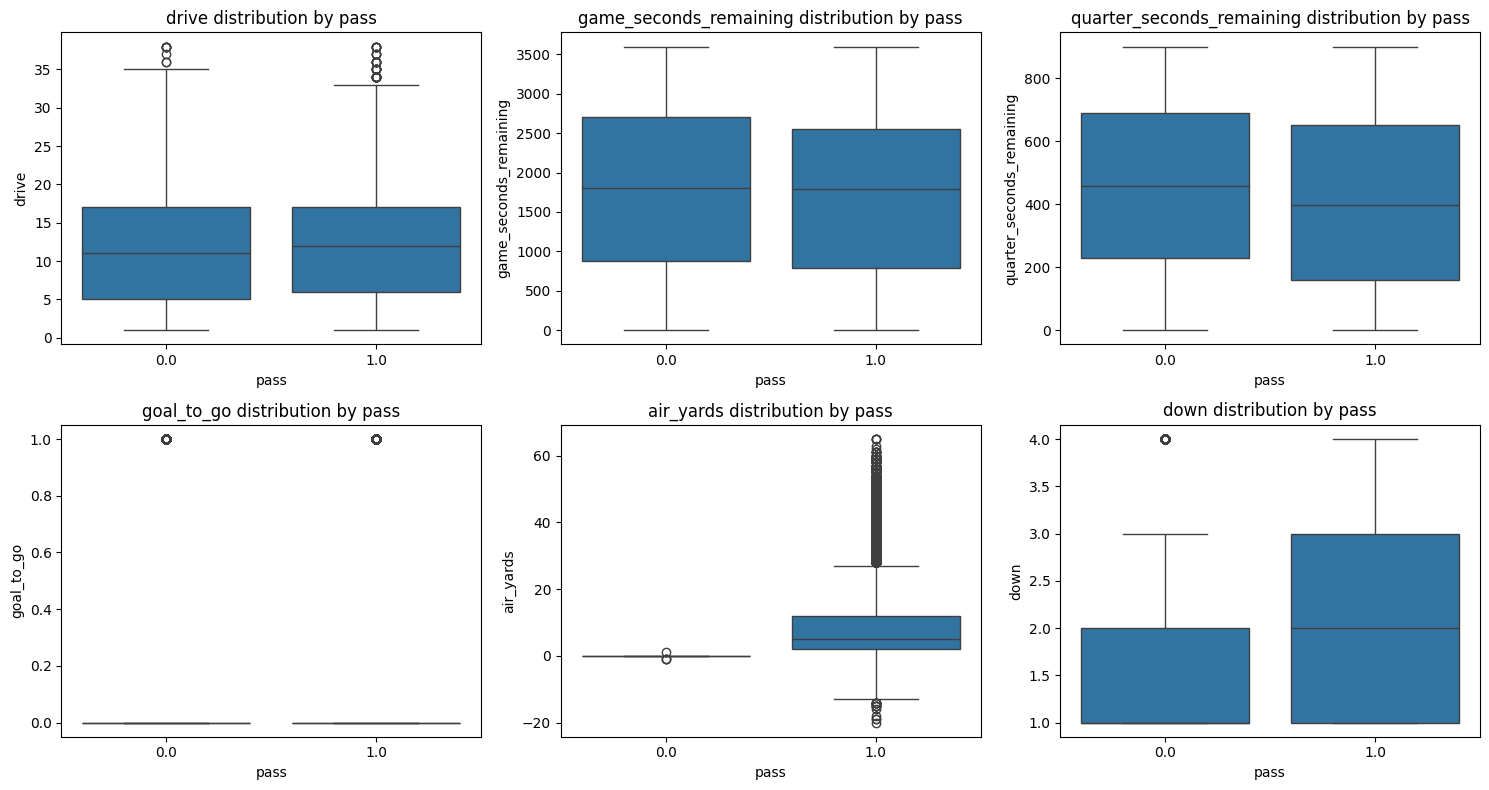

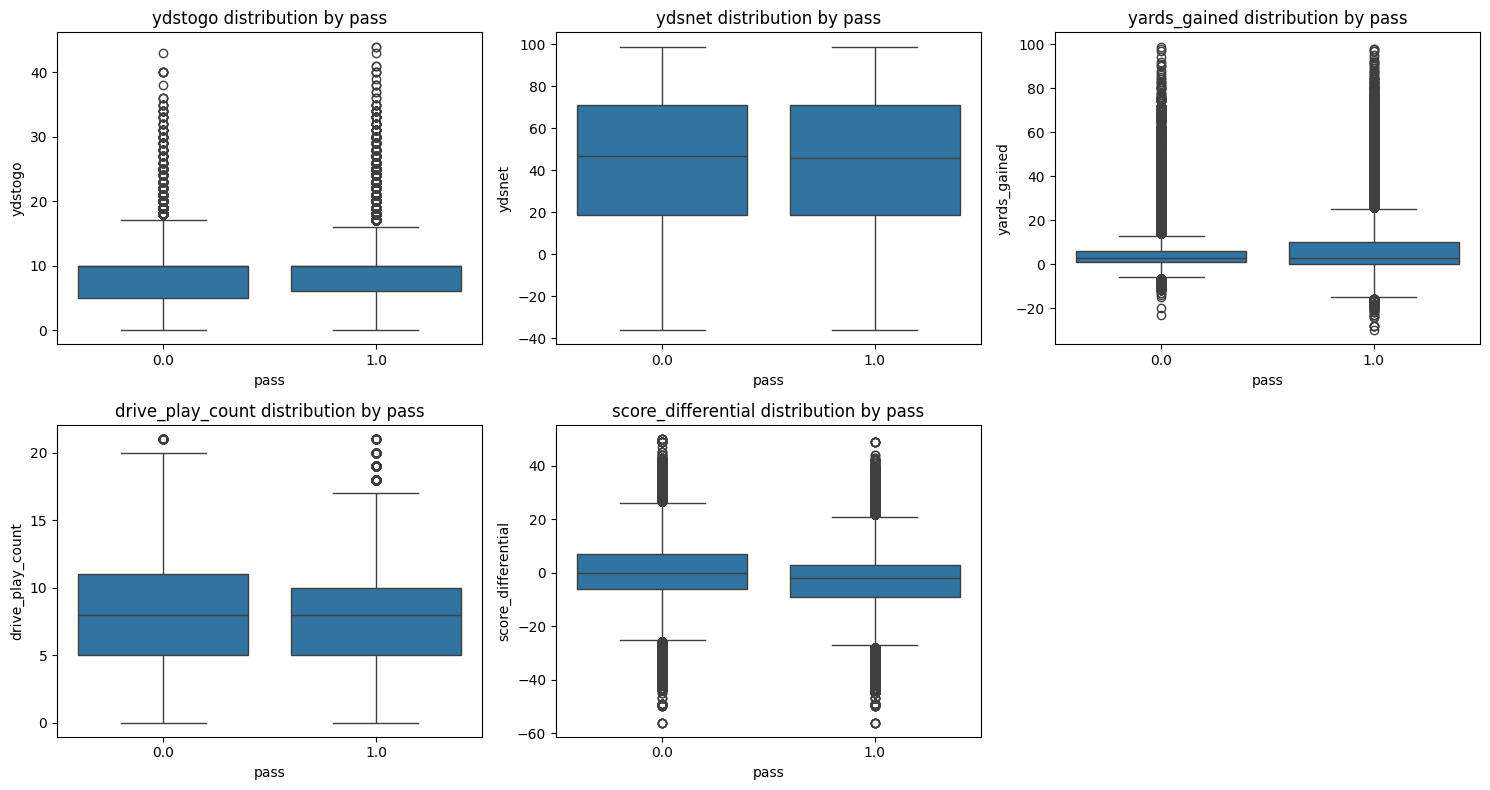

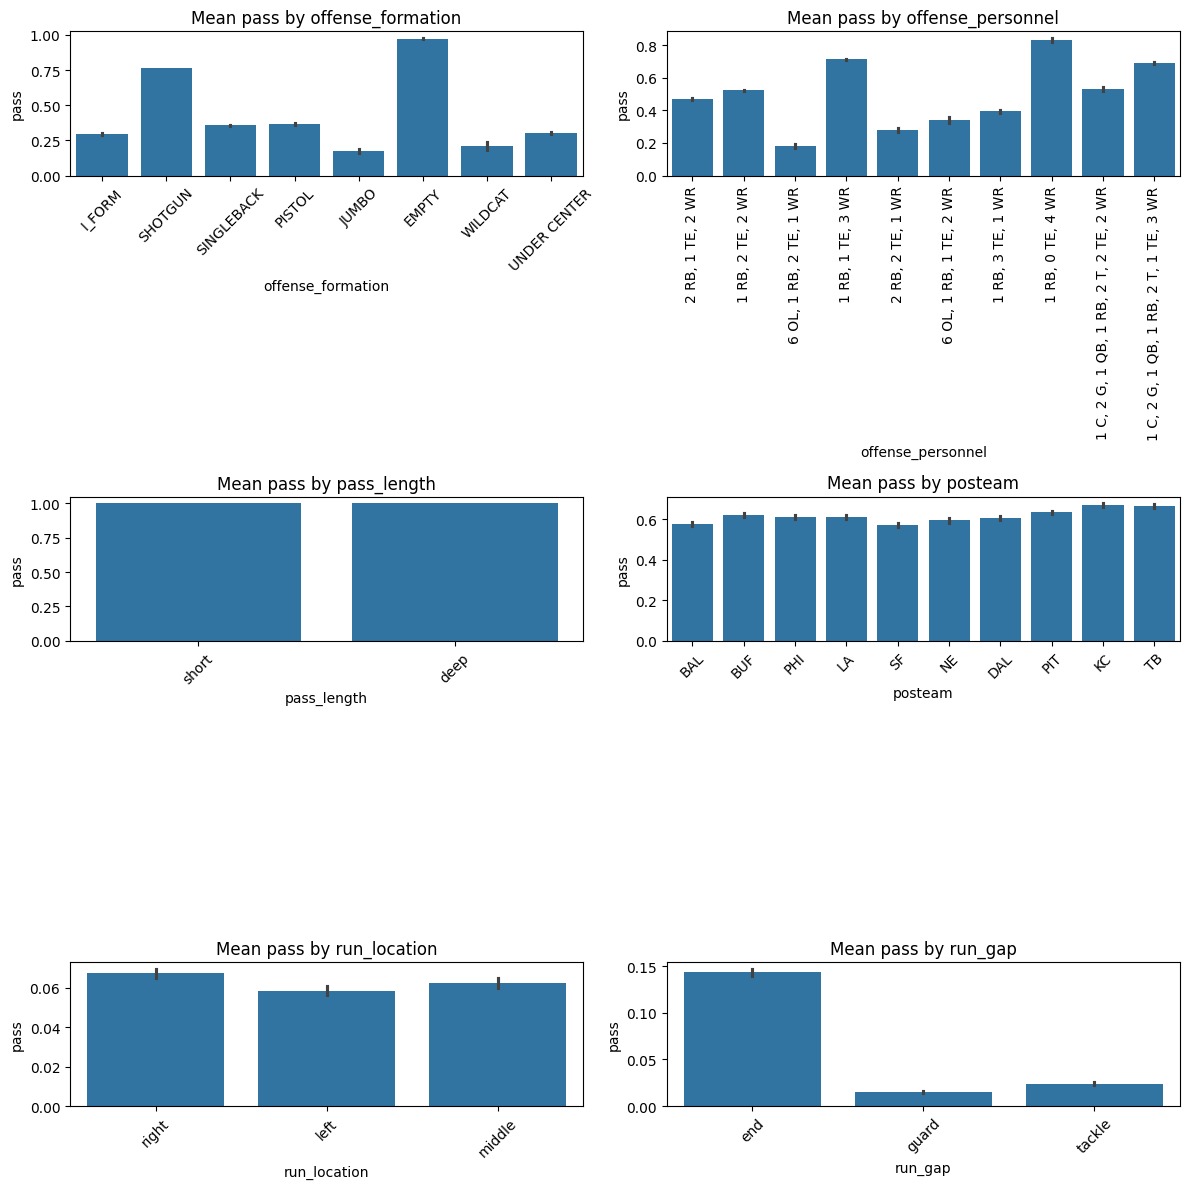

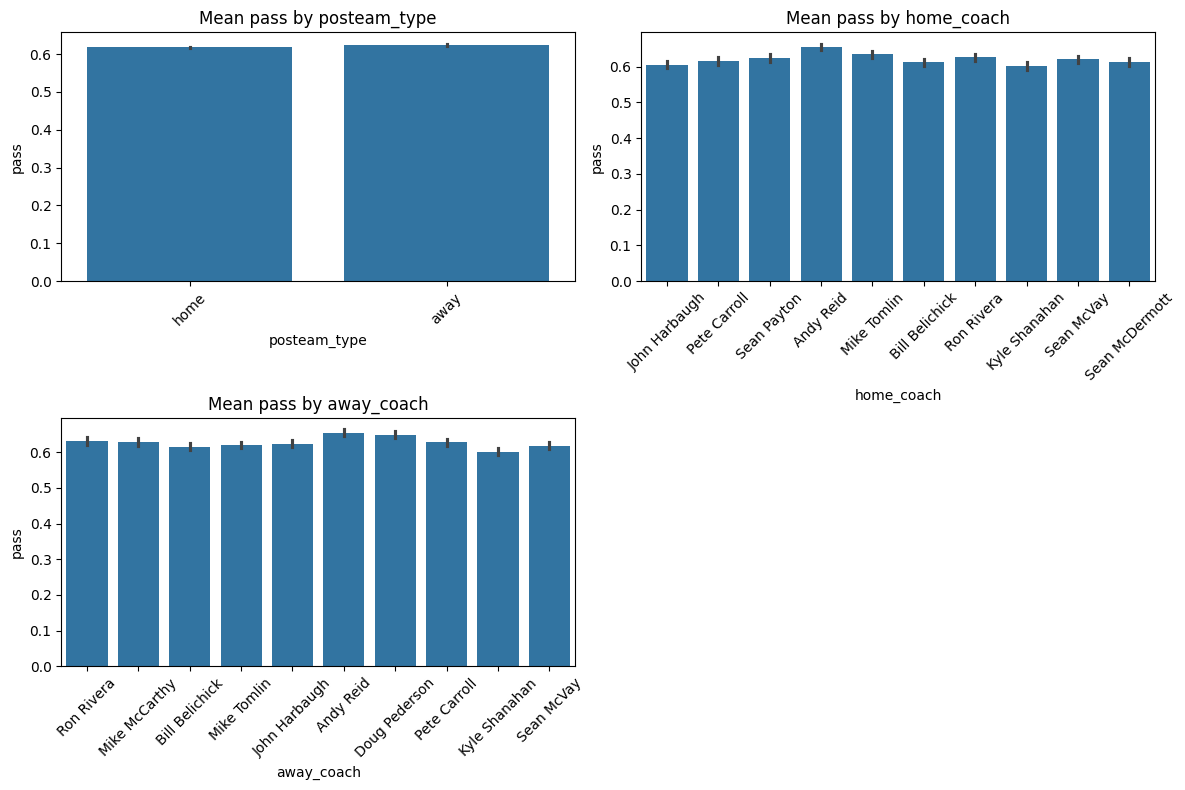

In [8]:
def plot_numerical_by_target(df, num_cols, target, plots_per_batch=6, plots_per_row=3):
    batches = math.ceil(len(num_cols) / plots_per_batch)

    for b in range(batches):
        batch_cols = num_cols[b * plots_per_batch : (b + 1) * plots_per_batch]
        num_plots = len(batch_cols)
        num_rows = math.ceil(num_plots / plots_per_row)

        fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 5, num_rows * 4))
        axes = axes.flatten() if num_plots > 1 else [axes]

        for i, col in enumerate(batch_cols):
            sns.boxplot(x=target, y=col, data=df, ax=axes[i])
            axes[i].set_title(f'{col} distribution by {target}')
            axes[i].set_xlabel(target)
            axes[i].set_ylabel(col)

        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()

def plot_categorical_by_target(df, cat_cols, target, plots_per_batch=6, plots_per_row=2):
    batches = math.ceil(len(cat_cols) / plots_per_batch)

    for b in range(batches):
        batch_cols = cat_cols[b * plots_per_batch : (b + 1) * plots_per_batch]
        num_plots = len(batch_cols)
        num_rows = math.ceil(num_plots / plots_per_row)

        fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 6, num_rows * 4))
        axes = axes.flatten() if num_plots > 1 else [axes]

        for i, col in enumerate(batch_cols):
            vc = df[col].value_counts().head(10).index
            top10featuredf = df[df[col].isin(vc)]

            sns.barplot(x=col, y=target, data=top10featuredf, estimator=np.mean, ax=axes[i])
            axes[i].set_title(f'Mean {target} by {col}')
            if col == "offense_personnel":
                axes[i].tick_params(axis='x', rotation=90)
            else:
                axes[i].tick_params(axis='x', rotation=45)

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()

plot_numerical_by_target(featuredf, num_cols, target)
plot_categorical_by_target(featuredf, cat_cols, target)

### Feature Correlation
First check of correlation among numerical features, showing correlation matrix and VIF values. 
- There are multiple high VIF values that we aim to fix with our new choice of features.

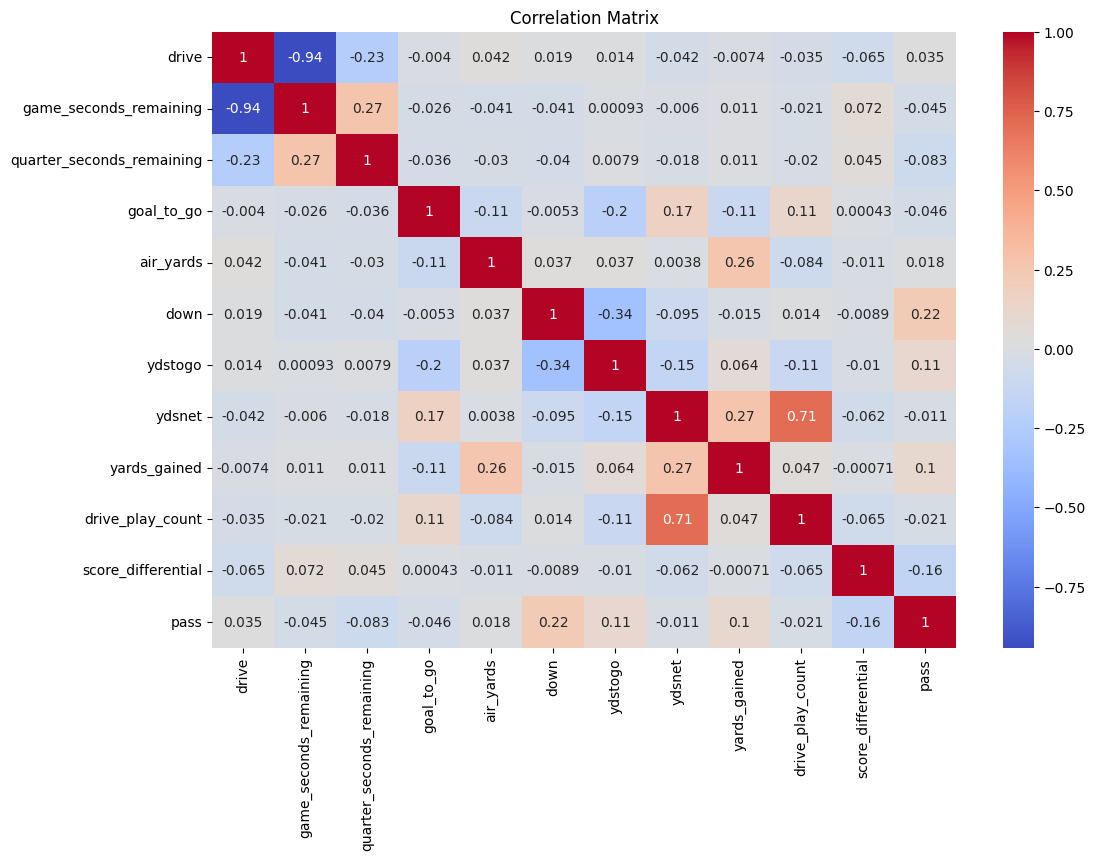

,Feature,VIF
0,drive,7.708228
1,game_seconds_remaining,7.658412
2,quarter_seconds_remaining,3.600889
3,goal_to_go,1.139306
4,air_yards,1.775533
5,down,6.351599
6,ydstogo,6.315387
7,ydsnet,9.125779
8,yards_gained,2.054108
9,drive_play_count,12.635808


In [9]:
def get_correlation(num_cols):
    # Correlation heatmap (numerical only)
    plt.figure(figsize=(12, 8))
    corr = featuredf[num_cols + [target]].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()
    
    # VIF check for multicollinearity
    X = featuredf[num_cols].drop(columns='pass', errors='ignore').dropna()
    
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

get_correlation(num_cols.to_list())

From this EDA, passing plays represent 62% of the total plays, indicating a class imbalance. To address this, the model applies `class_weight='balanced'`, which assigns higher importance to the minority class by weighting classes inversely to their frequency. This ensures the model treats pass and rush plays more equally during training. High VIF values indicate multicollinearity among features, so some features are removed to reduce redundancy, while additional features are included to enhance the overall robustness of the feature set.

## Feature Construction
Following the initial data exploration and a draft feature set, additional features were engineered to enrich the feature space, including:
- **Previous play yards gained/lost:** Preceding play yardage outcome helps assess momentum.
- **Previous play type:** Records whether the last play was a pass or rush, providing recent playcalling context.
- **Offensive coach:** Identifies the coach as coaching style can influence decisions.
- **Play number in drive:** Counts how many plays have occurred in the current drive, indicating game flow and drive progression.
- **Total pass and rush plays in drive:** Tracs the cumulative number of pass and rush plays called so far in the drive, giving insight into the offensive strategy.
- **Pass rate in drive:** Calculates the proportion of pass plays within the current drive to capture passing tendencies.

In [10]:
# Previous play yards gained/lost
featuredf['prev_ydgain'] = df['yards_gained'].shift(1)

# Previous play type
featuredf['prev_playtype'] = df['play_type'].shift(1)

# Get offensive coach
featuredf['off_coach'] = np.where(
    featuredf['posteam_type'] == 'home',
    featuredf['home_coach'],
    featuredf['away_coach']
)

# Number of plays in drive so far
featuredf['play_number_in_drive'] = (
    featuredf.groupby(['game_id', 'drive'])
    .cumcount()
)

# Number of pass/rush plays called in the current drive so far
groupedpass = featuredf.groupby(['game_id', 'drive'])['pass']
featuredf['drive_total_pass'] = groupedpass.shift(1).fillna(0).groupby([df['game_id'], df['drive']]).cumsum()
groupedrush = featuredf.groupby(['game_id', 'drive'])['rush']
featuredf['drive_total_rush'] = groupedrush.shift(1).fillna(0).groupby([df['game_id'], df['drive']]).cumsum()

# Pass rate in the current drive so far
featuredf['pass_rate_in_drive'] = featuredf['drive_total_pass'] / featuredf['play_number_in_drive']

featuredf.head(10)

,game_id,offense_formation,offense_personnel,drive,game_seconds_remaining,quarter_seconds_remaining,goal_to_go,yrdln,pass_length,posteam,...,pass,rush,play,prev_ydgain,prev_playtype,off_coach,play_number_in_drive,drive_total_pass,drive_total_rush,pass_rate_in_drive
95753,2016_01_BUF_BAL,I_FORM,"2 RB, 1 TE, 2 WR",1.0,3597.0,897.0,0,BAL 14,None,BAL,...,0.0,1.0,1.0,0.0,kickoff,John Harbaugh,0.0,0.0,0.0,NaN
95754,2016_01_BUF_BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",1.0,3572.0,872.0,0,BAL 20,short,BAL,...,1.0,0.0,1.0,6.0,run,John Harbaugh,1.0,0.0,1.0,0.000000
95755,2016_01_BUF_BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",1.0,3541.0,841.0,0,BAL 25,None,BAL,...,0.0,1.0,1.0,5.0,pass,John Harbaugh,2.0,1.0,1.0,0.500000
95756,2016_01_BUF_BAL,I_FORM,"2 RB, 1 TE, 2 WR",1.0,3515.0,815.0,0,BAL 25,short,BAL,...,1.0,0.0,1.0,0.0,run,John Harbaugh,3.0,1.0,2.0,0.333333
95757,2016_01_BUF_BAL,I_FORM,"1 RB, 2 TE, 2 WR",1.0,3474.0,774.0,0,BAL 34,None,BAL,...,0.0,1.0,1.0,9.0,pass,John Harbaugh,4.0,2.0,2.0,0.500000
95760,2016_01_BUF_BAL,SHOTGUN,"1 RB, 2 TE, 2 WR",2.0,3404.0,704.0,0,BUF 32,short,BUF,...,1.0,0.0,1.0,0.0,punt,Rex Ryan,0.0,0.0,0.0,NaN
95761,2016_01_BUF_BAL,SHOTGUN,"6 OL, 1 RB, 2 TE, 1 WR",2.0,3362.0,662.0,0,BUF 34,None,BUF,...,0.0,1.0,1.0,2.0,pass,Rex Ryan,1.0,1.0,0.0,1.000000
95762,2016_01_BUF_BAL,SHOTGUN,"1 RB, 1 TE, 3 WR",2.0,3315.0,615.0,0,BUF 28,short,BUF,...,1.0,0.0,1.0,-6.0,run,Rex Ryan,2.0,1.0,1.0,0.500000
95764,2016_01_BUF_BAL,SHOTGUN,"1 RB, 2 TE, 2 WR",3.0,3273.0,573.0,0,BAL 34,short,BAL,...,1.0,0.0,1.0,0.0,punt,John Harbaugh,0.0,0.0,0.0,NaN
95765,2016_01_BUF_BAL,SHOTGUN,"1 RB, 2 TE, 2 WR",3.0,3245.0,545.0,0,BAL 37,short,BAL,...,1.0,0.0,1.0,3.0,pass,John Harbaugh,1.0,1.0,0.0,1.000000


### Updated Feature Correlation
A second correlation check using the updated numerical features shows significantly improved VIF values, indicating reduced multicollinearity.

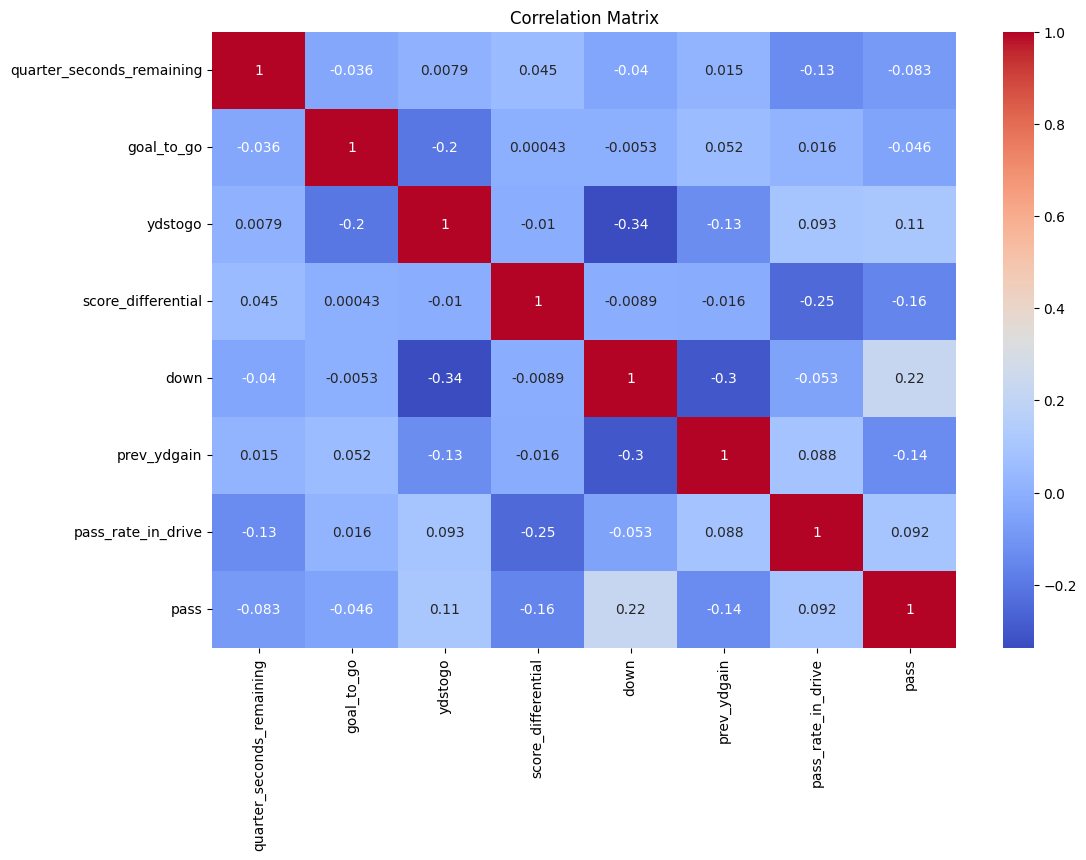

,Feature,VIF
0,quarter_seconds_remaining,3.214952
1,goal_to_go,1.083367
2,ydstogo,3.564994
3,score_differential,1.091150
4,down,3.989132
5,prev_ydgain,1.522737
6,pass_rate_in_drive,3.962845


In [11]:
num_cols = ["quarter_seconds_remaining", "goal_to_go", "ydstogo", "score_differential", 'down',
                    'prev_ydgain', 'pass_rate_in_drive']

get_correlation(num_cols)

## Feature Importance
A Random Forest model is used to showcase the top 20 feature importances in the feature space.

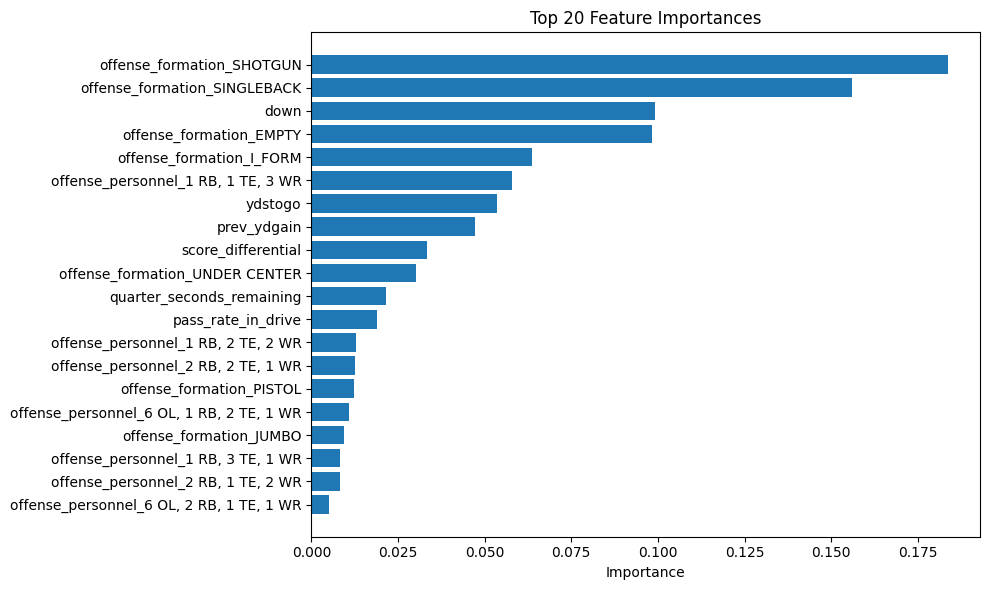

,feature,importance
20,offense_formation_SHOTGUN,0.183734
21,offense_formation_SINGLEBACK,0.155995
4,down,0.099276
16,offense_formation_EMPTY,0.098181
17,offense_formation_I_FORM,0.063657
243,"offense_personnel_1 RB, 1 TE, 3 WR",0.057925
2,ydstogo,0.053665
5,prev_ydgain,0.047094
3,score_differential,0.033441
22,offense_formation_UNDER CENTER,0.030301


In [12]:
def get_feature_importances(df):
    """Train a Random Forest on preprocessed data and plot top 20 feature importances."""
    
    # Features
    cat_features = ['prev_playtype', 'offense_formation', 'offense_personnel', 'off_coach']
    num_features = ["quarter_seconds_remaining", "goal_to_go", "ydstogo", "score_differential", 'down',
                    'prev_ydgain', 'pass_rate_in_drive'
                   ]

    # Target vals: (1) pass, (0) rush
    X = df[cat_features + num_features]
    y = df['pass']

    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
        ]
    )

    # Build pipeline with RF
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=200, max_depth=10, class_weight='balanced',
            random_state=93, n_jobs=-1
        ))
    ])

    # Fit
    pipeline.fit(X, y)

    # Get feature importances
    model = pipeline.named_steps['classifier']
    ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
    cat_feature_names = ohe.get_feature_names_out(cat_features)
    full_feature_names = np.concatenate([num_features, cat_feature_names])
    importances = model.feature_importances_

    # Plot feature importances
    feature_importance_df = pd.DataFrame({
        'feature': full_feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    top = feature_importance_df.head(20)
    plt.barh(top['feature'][::-1], top['importance'][::-1])
    plt.xlabel("Importance")
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()

    return top

get_feature_importances(featuredf)

It's unsurprising that `offense_formation` ranks among the most important features. However, the EMPTY formation was expected to stand out as the most important. The feature `down` also ranks highly, which aligns with expectations, as it often influences whether a team chooses to pass or rush.

## Helper Functions and Model Selection
Functions to preprocess data, get models (with preprocessing pipelines), train the models, and plot results

Each of the three models is evaluated using 5-fold cross-validation with three different hyperparameter configurations.

Model Selection:

- **Logistic Regression:**  
  A foundational linear model often used as a baseline for binary classification    
  **Pros:** Fast to train and effective when the relationship between features and target is linear   
  **Cons:** Can struggle with complex or nonlinear patterns

- **Random Forest:**  
  An ensemble approach that builds multiple decision trees using random subsets of the data   
  **Pros:** Captures nonlinear relationships well  
  **Cons:** Slower to train and may overfit if not tuned

- **Gradient Boosting:**  
  Builds trees sequentially, where each tree corrects the errors of the previous one  
  **Pros:** Often delivers high accuracy and performs well on imbalanced or structured data  
  **Cons:** Computationally more demanding and requires careful tuning to avoid overfitting

In [13]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def preprocess_data(X, cat_features, num_features):
    """Returns a ColumnTransformer to preprocess numerical and categorical features."""
    cat_set = set(cat_features)
    num_set = set(num_features)

    # Check for overlap
    overlap = cat_set & num_set
    if overlap:
        raise ValueError(f"Features cannot be in both categorical and numerical lists: {overlap}")
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
        ]
    )
    return preprocessor

def make_pipeline(preprocessor, model):
    """Helper to create a pipeline with preprocessor and a given model."""
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

def get_models(preprocessor):
    """Returns dictionary of pipelines with preprocessing + model variants."""
    
    logistic_params = [
        LogisticRegression(max_iter=1500, C=1.0, class_weight='balanced', random_state=93, n_jobs=-1),
        LogisticRegression(max_iter=1500, C=0.1, class_weight='balanced', random_state=93, n_jobs=-1),
        LogisticRegression(max_iter=1500, C=10, class_weight='balanced', random_state=93, n_jobs=-1),
    ]
    
    random_forest_params = [
        RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=93, n_jobs=-1),
        RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=93, n_jobs=-1),
        RandomForestClassifier(n_estimators=200, max_depth=20, class_weight='balanced', random_state=93, n_jobs=-1),
    ]
    
    gradient_boosting_params = [
        GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=93),
        GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=93),
        GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=5, random_state=93),
    ]

    return {
        'LogisticRegression': [make_pipeline(preprocessor, model) for model in logistic_params],
        'RandomForest': [make_pipeline(preprocessor, model) for model in random_forest_params],
        'GradientBoosting': [make_pipeline(preprocessor, model) for model in gradient_boosting_params],
    }

def evaluate_models(models, X, y, csv_path=None):
    """Cross-validates all models and optionally saves performance metrics to a CSV."""
    results = []
    scoring = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall']

    for model_name, model_variants in models.items():
        for i, model in enumerate(model_variants):

            params = model.get_params()
            # Only keep the parameters that are changing
            if isinstance(model.named_steps['classifier'], LogisticRegression):
                key_params = {k[12:]: params[k] for k in ['classifier__C']}
                short_key = 'C'
            elif isinstance(model.named_steps['classifier'], RandomForestClassifier):
                key_params = {k[12:]: params[k] for k in ['classifier__n_estimators', 'classifier__max_depth']}
                short_key = 'n_estimators'
            elif isinstance(model.named_steps['classifier'], GradientBoostingClassifier):
                key_params = {k[12:]: params[k] for k in ['classifier__n_estimators', 'classifier__max_depth', 'classifier__learning_rate']}
                short_key = 'n_estimators'
            
            # Convert to string
            param_str = "_".join(f"{k}={v}" for k, v in key_params.items())
            config_name = f"{model_name}_{param_str}"

            param_str_short = f"{short_key}={key_params.get(short_key)}"
            config_name_short = f"{model_name}_{param_str_short}"
            
            logger.info(f"Training {config_name}")
            start_time = time.time()

            cv_results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1)
            elapsed = time.time() - start_time

            result = {
                'model': model_name,
                'config': config_name,
                'config_short': config_name_short,
                'accuracy': np.mean(cv_results['test_accuracy']),
                'f1_score': np.mean(cv_results['test_f1']),
                'roc_auc': np.mean(cv_results['test_roc_auc']),
                'precision': np.mean(cv_results['test_precision']),
                'recall': np.mean(cv_results['test_recall']),
                'train_time_sec': elapsed
            }
            results.append(result)

    results_df = pd.DataFrame(results)

    if csv_path:
        results_df.to_csv(csv_path, index=False)
        logger.info(f"Results saved to {csv_path}")

    return results_df

def plot_results(results_df):
    """Plots bar chart of model performance metrics."""
    metrics = ['accuracy', 'f1_score', 'roc_auc', 'precision', 'recall']
    x = np.arange(len(results_df))
    width = 0.15

    _, ax = plt.subplots(figsize=(12, 6))
    for i, metric in enumerate(metrics):
        offset = (i - 2) * width  # Center bars
        ax.bar(x + offset, results_df[metric], width, label=metric)

    ax.set_ylim(0,.95)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_short'], rotation=45)
    ax.set_ylabel("Score")
    ax.set_title("Model Performance Metrics")
    ax.legend(loc='upper left', ncols=len(metrics))
    plt.tight_layout()
    plt.show()

## Main Function
- Calls helper functions and evaluates the models
- Target is whether the play is a pass (1) or not (0)

In [14]:
def main():
    # Features
    cat_features = ['prev_playtype', 'offense_formation', 'offense_personnel', 'off_coach']
    num_features = ["quarter_seconds_remaining", "goal_to_go", "ydstogo", "score_differential", 'down',
                    'prev_ydgain', 'pass_rate_in_drive'
                   ]

    # Target values are (1) pass, (0) rush
    X = featuredf[cat_features + num_features]
    y = featuredf['pass']

    # Build preprocessor
    preprocessor = preprocess_data(X, cat_features, num_features)
    
    # Get models (with preprocessing)
    models = get_models(preprocessor)
    
    # Evaluation
    results_df = evaluate_models(models, X, y, csv_path="model_results.csv")

    # Show results
    print(results_df.sort_values(by='roc_auc', ascending=False).round(5))
    plot_results(results_df)

INFO:__main__:Training LogisticRegression_C=1.0
INFO:__main__:Training LogisticRegression_C=0.1
INFO:__main__:Training LogisticRegression_C=10
INFO:__main__:Training RandomForest_n_estimators=50_max_depth=None
INFO:__main__:Training RandomForest_n_estimators=100_max_depth=10
INFO:__main__:Training RandomForest_n_estimators=200_max_depth=20
INFO:__main__:Training GradientBoosting_n_estimators=50_max_depth=3_learning_rate=0.1
INFO:__main__:Training GradientBoosting_n_estimators=100_max_depth=3_learning_rate=0.05
INFO:__main__:Training GradientBoosting_n_estimators=200_max_depth=5_learning_rate=0.01
INFO:__main__:Results saved to model_results.csv


                model                                             config  \
8    GradientBoosting  GradientBoosting_n_estimators=200_max_depth=5_...   
5        RandomForest         RandomForest_n_estimators=200_max_depth=20   
7    GradientBoosting  GradientBoosting_n_estimators=100_max_depth=3_...   
6    GradientBoosting  GradientBoosting_n_estimators=50_max_depth=3_l...   
3        RandomForest        RandomForest_n_estimators=50_max_depth=None   
4        RandomForest         RandomForest_n_estimators=100_max_depth=10   
1  LogisticRegression                           LogisticRegression_C=0.1   
0  LogisticRegression                           LogisticRegression_C=1.0   
2  LogisticRegression                            LogisticRegression_C=10   

                        config_short  accuracy  f1_score  roc_auc  precision  \
8  GradientBoosting_n_estimators=200   0.74963   0.80010  0.82303    0.79334   
5      RandomForest_n_estimators=200   0.74617   0.78826  0.82291    0.81727   

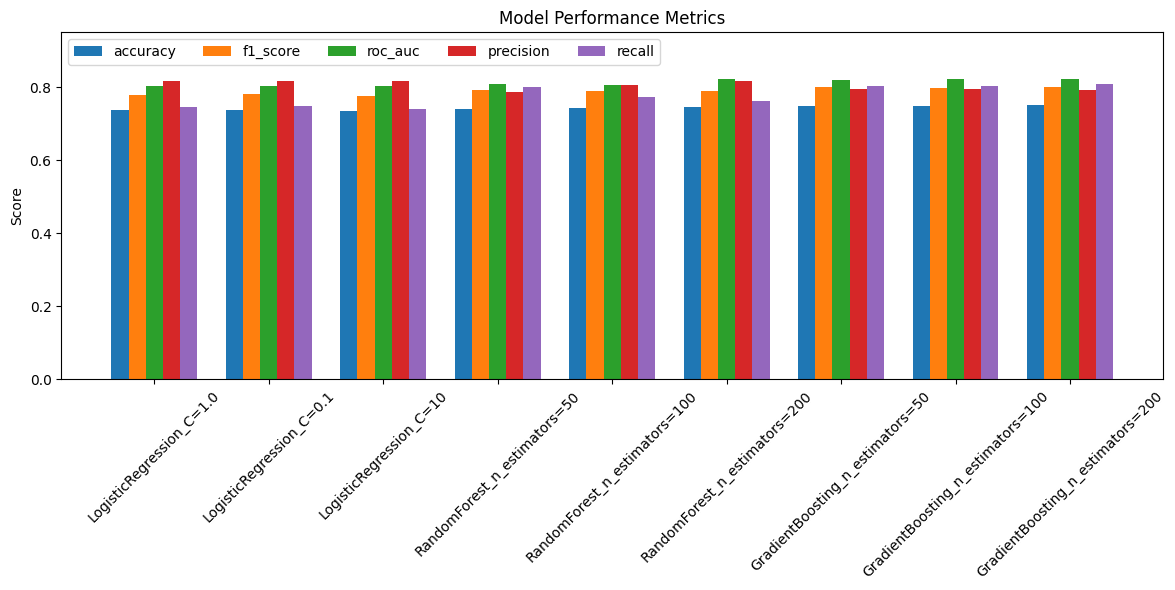

In [15]:
# Call Main
if __name__ == "__main__":
    main()

## Summary

This project explored the prediction of NFL play calls (pass vs. rush) using play-by-play data from 2014–2023. Models were trained using features such as offensive formation, personnel, down, distance, and score differential.

Gradient Boosting and Random Forest performed best, as was expected, since these models can capture the non-linear factors such as down and distance or formation and score differential. Logistic Regression was slightly worse but was the fastest model tested. Gradient Boosting also had the highest recall rates among all models. One challenge was class imbalance, since passing plays are more common, but the models were able to overcome this with the right tuning. Overall performance was fairly consistent across all nine configurations, though certain hyperparameter settings led to minor improvements in the results.

Overall, the models demonstrate that play type can be predicted with a reasonable level of accuracy using the selected features. However, performance is limited by missing context and unavailable variables. Future improvements could involve incorporating injury reports, depth chart data, and other game-specific details. Further refinement could also include reframing the task as a multiclass problem (e.g., distinguishing between inside/outside runs or short/deep passes) and exploring sequential models like LSTMs or transformer-based models to capture play-to-play dynamics and model long-term dependencies. Beyond model architecture, richer data representations could be leveraged through learned embeddings. For instance, instead of one-hot encoding categorical fields like coaches or teams, embeddings could be used to capture deeper relationships. These embeddings could group similar coaches or teams together based on features like past performance, textual descriptions, or play style.